# Import libraries

In [42]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import sys
import random
from typing import List

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from rimworld.utils import read_metadata #, one_hot_encode

In [32]:
# Ik wil deze gewoon importen van utils maar dat mag niet om een of andere reden.


def one_hot_encode(lst: np.ndarray, classes = 11):
    one_hot_encoded = np.zeros((lst.size, classes), dtype=int)
    one_hot_encoded[np.arange(lst.size), lst] = 1
    
    return one_hot_encoded.tolist()

# Get train STFT data and labels (Nsynth JSON data)

In [59]:
data_dir = r"D:\Projects\nsynth-data\data\stft\train"
train_data_dir = pathlib.Path(data_dir)

label_dir = r"D:\Projects\nsynth-data\data/nsynth-train"
train_jsondata = read_metadata(label_dir).sort_index()
labels = train_jsondata.instrument_family


# Get test STFT data and labels

In [60]:
test_data_dir = r"D:\Projects\nsynth-data\data\stft\test"
test_data_dir = pathlib.Path(test_data_dir)

label_dir = r"D:\Projects\nsynth-data\data/nsynth-test"
test_jsondata = read_metadata(label_dir).sort_index()
test_labels = test_jsondata.instrument_family

# View image for inspection

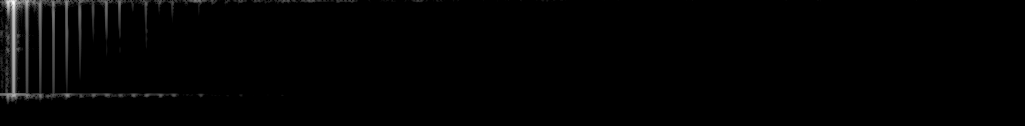

In [61]:
bass_acoustic = list(train_data_dir.glob('bass_acoustic*'))
PIL.Image.open(str(bass_acoustic[100]))


In [62]:
import imageio

im = imageio.imread(str(bass_acoustic[100]))
print(im[0])

[[ 25  25  25 255]
 [ 47  47  47 255]
 [ 77  77  77 255]
 ...
 [  0   0   0 255]
 [  0   0   0 255]
 [  0   0   0 255]]


# View JSON-data and labels



In [63]:
labels

bass_acoustic_000-024-025       0
bass_acoustic_000-024-050       0
bass_acoustic_000-024-075       0
bass_acoustic_000-024-100       0
bass_acoustic_000-024-127       0
                               ..
vocal_synthetic_015-096-025    10
vocal_synthetic_015-096-050    10
vocal_synthetic_015-096-075    10
vocal_synthetic_015-096-100    10
vocal_synthetic_015-096-127    10
Name: instrument_family, Length: 289205, dtype: int64

In [64]:
images = list(train_data_dir.glob('*.png'))
image_count = len(images)
print(image_count)
[images[0:5], images[-5:]]

289205


[[WindowsPath('D:/Projects/nsynth-data/data/stft/train/bass_acoustic_000-024-025.wav.png'),
  WindowsPath('D:/Projects/nsynth-data/data/stft/train/bass_acoustic_000-024-050.wav.png'),
  WindowsPath('D:/Projects/nsynth-data/data/stft/train/bass_acoustic_000-024-075.wav.png'),
  WindowsPath('D:/Projects/nsynth-data/data/stft/train/bass_acoustic_000-024-100.wav.png'),
  WindowsPath('D:/Projects/nsynth-data/data/stft/train/bass_acoustic_000-024-127.wav.png')],
 [WindowsPath('D:/Projects/nsynth-data/data/stft/train/vocal_synthetic_015-096-025.wav.png'),
  WindowsPath('D:/Projects/nsynth-data/data/stft/train/vocal_synthetic_015-096-050.wav.png'),
  WindowsPath('D:/Projects/nsynth-data/data/stft/train/vocal_synthetic_015-096-075.wav.png'),
  WindowsPath('D:/Projects/nsynth-data/data/stft/train/vocal_synthetic_015-096-100.wav.png'),
  WindowsPath('D:/Projects/nsynth-data/data/stft/train/vocal_synthetic_015-096-127.wav.png')]]

# Ensure x and y are the same size

In [65]:
assert image_count == len(labels.values)

# One hot encode the labels

In [66]:
labels = one_hot_encode(labels)
test_labels = one_hot_encode(test_labels)

In [76]:
print(len(images))
print(len(labels))
labels[0]

def get_label(path, label="instrument_family"):
    if label=="pitch":
        return int(path.split('-')[2])

    if label=="instrument_family":
        switch = {
            'bass': 0,
            'brass': 1,
            'flute': 2,
            'guitar': 3,
            'keyboard': 4,
            'mallet': 5,
            'organ': 6,
            'reed': 7,
            'string': 8,
            'synth': 9, 
            'vocal': 10,        
        }
        filename = os.path.split(path)[1]
        split = filename.split('_')
        return switch[filename.split('_')[0]]
    
    if label=="instrument":
        switch = {
            'bass_acoustic': 0,
            'bass_electronic': 1,
            'bass_synthetic': 2,
            'brass_acoustic': 3,
            'brass_electronic': 4,
            'brass_synthetic': 5,
            'flute_acoustic': 6,
            'flute_electronic': 7,
            'flute_synthetic': 8,
            'guitar_acoustic': 9,
            'guitar_electronic': 10,
            'guitar_synthetic': 11,
            'keyboard_acoustic': 12,
            'keyboard_electronic': 13,
            'keyboard_synthetic': 14,
            'mallet_acoustic': 15,
            'mallet_electronic': 16,
            'mallet_synthetic': 17,
            'organ_acoustic': 18,
            'organ_electronic': 19,
            'organ_synthetic': 20,
            'reed_acoustic': 21,
            'reed_electronic': 22,
            'reed_synthetic': 23,
            'string_acoustic': 24,
            'string_electronic': 25,
            'string_synthetic': 26,
            'synth_lead_acoustic': 27,
            'synth_lead_electronic': 28,
            'synth_lead_synthetic': 29,
            'vocal_acoustic': 30,
            'vocal_electronic': 31,
            'vocal_synthetic': 32,
            
        } 
        filename = os.path.split(path)[1]
        split = filename.split('_')
        if split[0] == "synth":
            res = split[0] + "_" + split[1] + "_" + split[2]
        else:
            res = split[0] + "_" + split[1]
        return switch[res]

def create_subdirectories_for_image_dataset_from_directory(data_paths: List, nr_of_labels):
    
    current_dir = str(test_data_dir)
    
    for i in range(nr_of_labels):
        labelclass = str(i)
        path = os.path.join(current_dir, labelclass)
        os.mkdir(path)
    
    for path in data_paths:
        label = get_label(path, "instrument_family")
        newpath = current_dir + "/" + str(label) + "/" + os.path.basename(path)

        os.rename(path, newpath)
        
#create_subdirectories_for_image_dataset_from_directory(images, 11)
test_images = list(test_data_dir.glob('*.png')) 
create_subdirectories_for_image_dataset_from_directory(test_images, 11)

        

289205
289205


# Load as train and val dataset with Keras


In [80]:


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir, 
    label_mode = 'categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode = 'grayscale'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir, 
    label_mode = 'categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode = 'grayscale'
)

Found 289205 files belonging to 11 classes.
Found 4096 files belonging to 11 classes.



batch_size = 32
img_height = 126
img_width = 1025

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir, 
    labels = labels,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [81]:
import keras
from glob import glob

# path = r'F:\Nsynth\stft\train\*.png'
# path = "../../nsynth-data/data/stft/train/*.png"
# batch_size = 16
# nr_of_labels=11
# gen = geenreet0r(path, batch_size, nr_of_labels)

batch_size = 16
img_height = 126
img_width = 1025
nr_of_labels=11

model = keras.Sequential([
    keras.layers.Input(shape=(126, 1025, 1)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(nr_of_labels, activation='softmax'),
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='categorical_accuracy')

model.summary()
history = model.fit(x=train_ds, epochs=3, batch_size=batch_size, validation_data=test_ds, verbose=1)

# plt.plot(history.history['val_categorical_accuracy'], label='Validation categorical accuracy')
# plt.plot(history.history['categorical_accuracy'], label='Training categorical accuracy')
# plt.legend()
# plt.title('NSynth instrument Detection Performance')
# plt.xlabel('Epochs')
# plt.ylabel('Categorical accuracy')
# plt.savefig('model')


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 124, 1023, 32)     320       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 41, 341, 32)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 39, 339, 64)       18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 13, 113, 64)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 11, 111, 128)      73856     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 3, 37, 128)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 14208)           

KeyboardInterrupt: 

In [ ]:
def load_sample(path):
    img = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale")
    img_array = keras.preprocessing.image.img_to_array(img)
    label = get_label(path)
    return img_array, label



def get_label(path, label="instrument_family"):
    if label=="pitch":
        return int(path.split('-')[2])

    if label=="instrument_family":
        switch = {
            'bass': 0,
            'brass': 1,
            'flute': 2,
            'guitar': 3,
            'keyboard': 4,
            'mallet': 5,
            'organ': 6,
            'reed': 7,
            'string': 8,
            'synth': 9, 
            'vocal': 10,        
        }
        filename = os.path.split(path)[1]
        split = filename.split('_')
        return switch[filename.split('_')[0]]
    
    if label=="instrument":
        switch = {
            'bass_acoustic': 0,
            'bass_electronic': 1,
            'bass_synthetic': 2,
            'brass_acoustic': 3,
            'brass_electronic': 4,
            'brass_synthetic': 5,
            'flute_acoustic': 6,
            'flute_electronic': 7,
            'flute_synthetic': 8,
            'guitar_acoustic': 9,
            'guitar_electronic': 10,
            'guitar_synthetic': 11,
            'keyboard_acoustic': 12,
            'keyboard_electronic': 13,
            'keyboard_synthetic': 14,
            'mallet_acoustic': 15,
            'mallet_electronic': 16,
            'mallet_synthetic': 17,
            'organ_acoustic': 18,
            'organ_electronic': 19,
            'organ_synthetic': 20,
            'reed_acoustic': 21,
            'reed_electronic': 22,
            'reed_synthetic': 23,
            'string_acoustic': 24,
            'string_electronic': 25,
            'string_synthetic': 26,
            'synth_lead_acoustic': 27,
            'synth_lead_electronic': 28,
            'synth_lead_synthetic': 29,
            'vocal_acoustic': 30,
            'vocal_electronic': 31,
            'vocal_synthetic': 32,
            
        } 
        filename = os.path.split(path)[1]
        split = filename.split('_')
        if split[0] == "synth":
            res = split[0] + "_" + split[1] + "_" + split[2]
        else:
            res = split[0] + "_" + split[1]
        return switch[res]
    

def reset(batch_size, nr_of_labels=128):
    imgs = np.zeros((batch_size, 126, 1025, 1))
    labels = np.zeros((batch_size, nr_of_labels))
    return imgs, labels

def geenreet0r(path, batch_size, nr_of_labels=128):
    files = glob(path)
    random.shuffle(files)
    imgs, labels = reset(batch_size, nr_of_labels)
    for i, file in enumerate(files):
        in_batch_id = i % batch_size
        if i > 0 and in_batch_id == 0:
            # Send last batch
            yield imgs, labels
            imgs, labels = reset(batch_size, nr_of_labels)
        img, label = load_sample(file)
        imgs[in_batch_id] = img
        labels[in_batch_id, label] = 1  # Dummy coding
    else:
        # Shut down generator
        # TODO: return final batch?
        return None